In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import random
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import pickle
import glob
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from time import process_time
from imblearn.over_sampling import RandomOverSampler

In [69]:
data = pd.read_csv("https://raw.githubusercontent.com/lihkir/Data/main/api_call_sequence_per_malware.csv")
data.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


### Características

Nombre de la columna: hash

Descripción: El hash MD5 del ejemplo

Tipo: Cadena de 32 bytes

Nombre de columna: t_0, t_1,…, t99 (100 intentos)

Descripción: Llamada a la API

Valores: Cantidad de llamadas

Tipo: Entero (0-306)

Nombre de columna: malware

Descripción: Clase

Tipo: Entero: 0 (Goodware) o 1 (Malware)

## Exploratory Data Analysis

In [54]:
def idx_lr(data, n_new_cols):
    n_data_cols = len(data.columns)
    idx_l  = sorted(list(range(n_new_cols - 1, -1, -1)))
    idx_r  = sorted(list(range(n_data_cols - 1, n_data_cols - n_new_cols - 1, -1)))
    return idx_l + idx_r

In [55]:
data.iloc[:, idx_lr(data, 4)].head()

,hash,t_0,t_1,t_2,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,260,141,260,1


In [56]:
print("# NaN values:", data.isna().sum().sum())

# NaN values: 0


In [57]:
data.dtypes

hash       object
t_0         int64
t_1         int64
t_2         int64
t_3         int64
            ...  
t_96        int64
t_97        int64
t_98        int64
t_99        int64
malware     int64
Length: 102, dtype: object

In [58]:
count_hash = data.groupby("hash", as_index=False).size().sort_values(by='size', ascending=False)
count_hash

,hash,size
42415,f78ea80cec007b2c32fb10f9c6c82f39,2
1253,075323e77815ee8bcc7854ce23955a15,2
27265,a71a2319cf8c74a89501eb80acd04fe6,2
10002,3d8a7a97ea954dd4fe66279df2b445e0,2
19638,79b78bb3d583748040c41ded09555fd3,2
...,...,...
14625,5a2fef03a0125e848be8ec6178df6b84,1
14626,5a326a6230a7d2a77a4a40e9061bed3b,1
14627,5a33efa4b07cb9959b0cfe40f7eadac2,1
14628,5a35278d935bf24050e567374e067bdd,1


In [59]:
sum(count_hash['size'] > 1)

9

In [60]:
data[data.duplicated()]

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
14665,075323e77815ee8bcc7854ce23955a15,16,172,274,158,215,274,158,215,274,...,215,274,158,215,274,158,215,274,158,0
16891,bdaaac3fa3f6796825a51ef1c0e5b3fd,82,240,117,240,117,240,117,240,117,...,260,65,260,141,65,112,113,65,289,0
21713,03384ab6368b68ed16ecb9e6352539af,16,172,274,158,215,274,158,215,274,...,215,274,158,215,274,158,215,274,158,0
33626,f78ea80cec007b2c32fb10f9c6c82f39,16,172,274,158,215,274,158,215,274,...,215,274,158,215,274,158,215,274,158,0


In [61]:
count_hash.query("size > 1")

,hash,size
42415,f78ea80cec007b2c32fb10f9c6c82f39,2
1253,075323e77815ee8bcc7854ce23955a15,2
27265,a71a2319cf8c74a89501eb80acd04fe6,2
10002,3d8a7a97ea954dd4fe66279df2b445e0,2
19638,79b78bb3d583748040c41ded09555fd3,2
16216,64261f6acf8e566a70ec8b62af8ccdb1,2
1386,0822ec2ba98d291e5bfc836bc3686096,2
32016,bdaaac3fa3f6796825a51ef1c0e5b3fd,2
555,03384ab6368b68ed16ecb9e6352539af,2


In [62]:
hash_review = [i for i in list(count_hash.query("size > 1")['hash']) if not i in list(data[data.duplicated()]['hash'])]
hash_review

['a71a2319cf8c74a89501eb80acd04fe6',
 '3d8a7a97ea954dd4fe66279df2b445e0',
 '79b78bb3d583748040c41ded09555fd3',
 '64261f6acf8e566a70ec8b62af8ccdb1',
 '0822ec2ba98d291e5bfc836bc3686096']

In [63]:
columns_calls = data.columns[1:][:-1]
columns_calls

Index(['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9',
       't_10', 't_11', 't_12', 't_13', 't_14', 't_15', 't_16', 't_17', 't_18',
       't_19', 't_20', 't_21', 't_22', 't_23', 't_24', 't_25', 't_26', 't_27',
       't_28', 't_29', 't_30', 't_31', 't_32', 't_33', 't_34', 't_35', 't_36',
       't_37', 't_38', 't_39', 't_40', 't_41', 't_42', 't_43', 't_44', 't_45',
       't_46', 't_47', 't_48', 't_49', 't_50', 't_51', 't_52', 't_53', 't_54',
       't_55', 't_56', 't_57', 't_58', 't_59', 't_60', 't_61', 't_62', 't_63',
       't_64', 't_65', 't_66', 't_67', 't_68', 't_69', 't_70', 't_71', 't_72',
       't_73', 't_74', 't_75', 't_76', 't_77', 't_78', 't_79', 't_80', 't_81',
       't_82', 't_83', 't_84', 't_85', 't_86', 't_87', 't_88', 't_89', 't_90',
       't_91', 't_92', 't_93', 't_94', 't_95', 't_96', 't_97', 't_98', 't_99'],
      dtype='object')

In [64]:
for i in hash_review:
    
    dup = sum(data.query("hash == @i").duplicated(subset=columns_calls))
    print(f"For hash {i}, there is {dup} duplicates")

For hash a71a2319cf8c74a89501eb80acd04fe6, there is 0 duplicates
For hash 3d8a7a97ea954dd4fe66279df2b445e0, there is 0 duplicates
For hash 79b78bb3d583748040c41ded09555fd3, there is 0 duplicates
For hash 64261f6acf8e566a70ec8b62af8ccdb1, there is 0 duplicates
For hash 0822ec2ba98d291e5bfc836bc3686096, there is 0 duplicates


In [70]:
len0 = data.shape
data = data.drop_duplicates()
lenf = data.shape
print(f"Old data shape: {len0}, New data shape: {lenf}.")

Old data shape: (43876, 102), New data shape: (43872, 102).


In [117]:
data_new = data.drop(columns=['hash'], axis=1)
data_new.shape

(43872, 101)

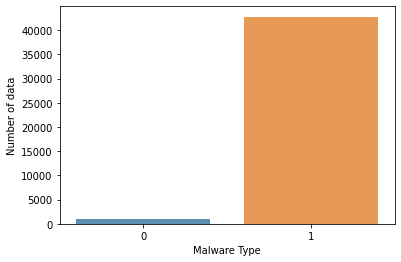

In [127]:
cnt_pro = data_new['malware'].value_counts()
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of data', fontsize=10)
plt.xlabel('Malware Type', fontsize=10);

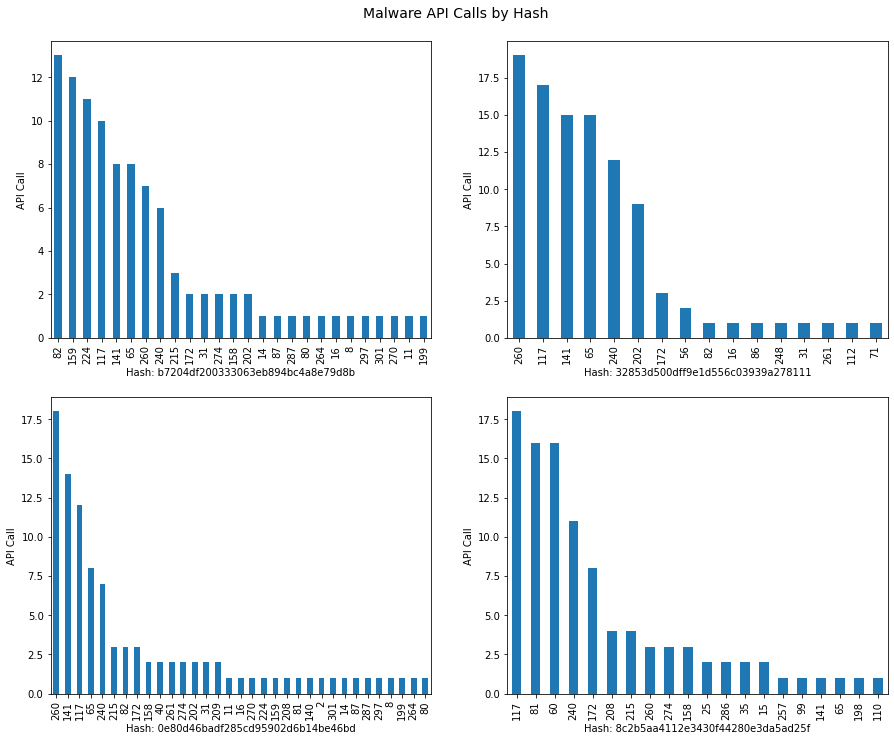

In [128]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("Malware API Calls by Hash", fontsize=14, y=0.92)

for i, ax in zip(range(1, 5), axs.ravel()):
    plt.subplot(2, 2, i)
    n_hash = random.randint(0, len(data_new))
    data_new.iloc[n_hash,:-1].value_counts().plot(kind='bar', xlabel='Hash: '+ data['hash'][n_hash], ylabel='API Call');

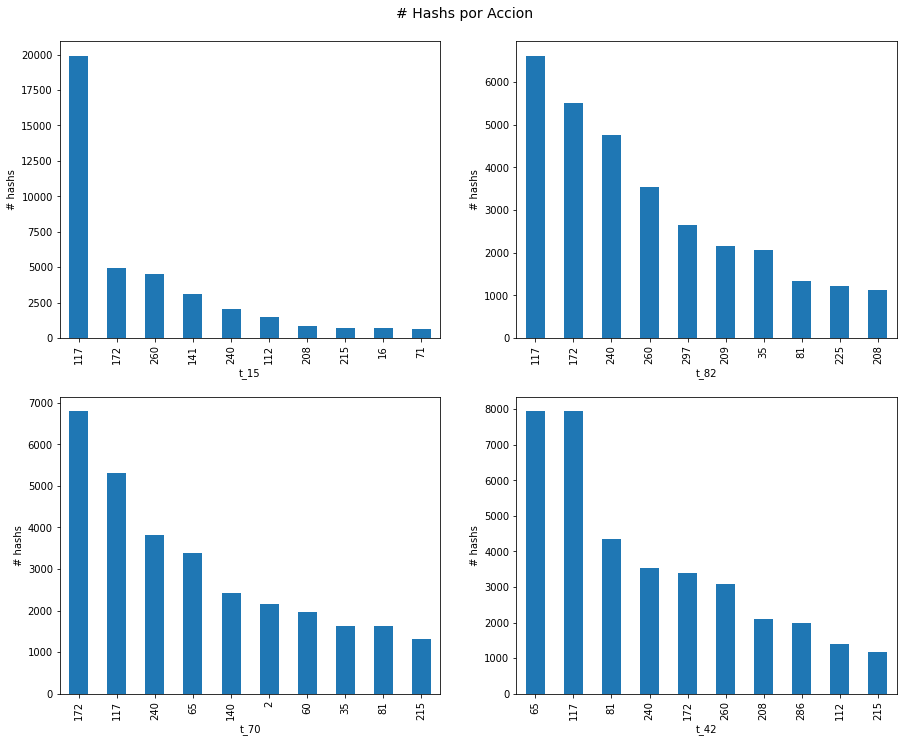

In [113]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

fig.suptitle("# Hashs por Accion", fontsize=14, y=0.92)

for i, ax in zip(range(1, 5), axs.ravel()):
    plt.subplot(2, 2, i)
    n_call = random.randint(0, 99)
    data_new[f't_{n_call}'].value_counts().head(10).plot(kind='bar', ylabel='# hashs');

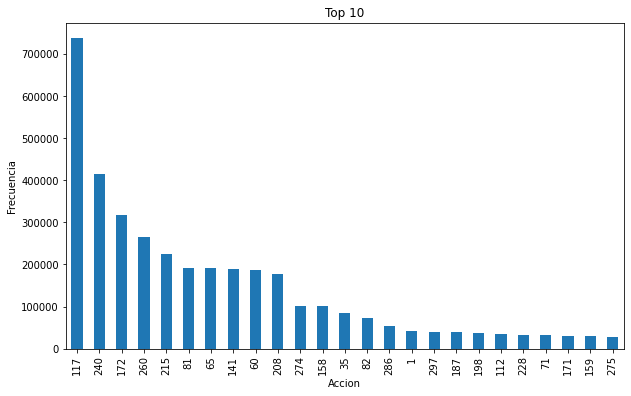

In [132]:
plt.figure(figsize=(10, 6))
data_new.stack().value_counts().head(25).plot(kind='bar', ylabel='Frecuencia', xlabel='Accion', title="Top 10");

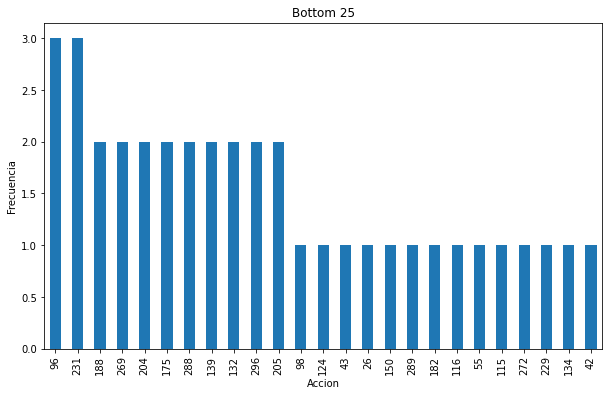

In [133]:
plt.figure(figsize=(10, 6))
fig.suptitle("# Hashs por Accion", fontsize=14, y=0.92)
data_new.stack().value_counts().tail(25).plot(kind='bar', ylabel='Frecuencia', xlabel='Accion', title="Bottom 25");

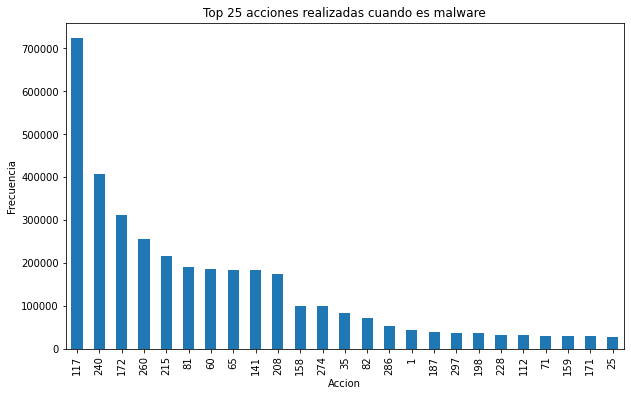

In [134]:
plt.figure(figsize=(10, 6))
data_new.query("malware == 1").stack().value_counts().head(25).plot(kind='bar', ylabel='Frecuencia', xlabel='Accion', title='Top 25 acciones realizadas cuando es malware');

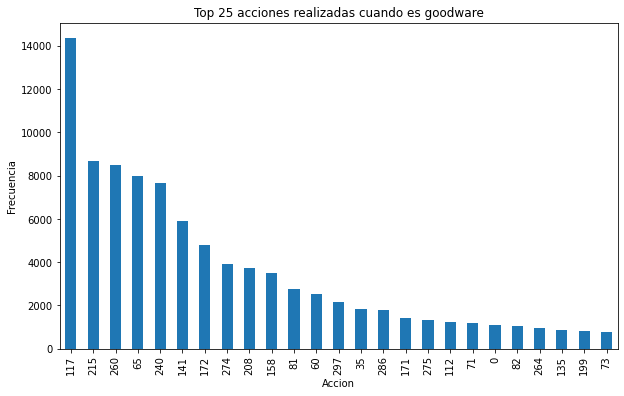

In [135]:
plt.figure(figsize=(10, 6))
data_new.query("malware == 0").stack().value_counts().head(25).plot(kind='bar', ylabel='Frecuencia', xlabel='Accion', title='Top 25 acciones realizadas cuando es goodware');

## Model design 

In [14]:
pipe = make_pipeline(StandardScaler(), MLPClassifier(max_iter=10000, random_state=42))

In [136]:
param_grid = {'mlpclassifier__alpha': [0.1, 0.01, 0.001],
              'mlpclassifier__hidden_layer_sizes': [(10,), (100,), (1000,)],
              'mlpclassifier__activation': ['logistic'],
              'mlpclassifier__learning_rate': ['constant']}

In [137]:
y = data_new['malware']
X = data_new.drop(['malware'], axis=1)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)


In [18]:
#pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [19]:
grid = None

if (len(glob.glob("grid_mlp.pkl")) != 0):
    grid = pickle.load(open('grid_mlp.pkl','rb'))
else:
    time_start = process_time()
    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
    grid.fit(X_train, y_train)
    time_stop = process_time()
    str_cpu_time = "GridSearchCV CPU time: " + str((time_stop-time_start)*0.6) + " minutes"
    print(str_cpu_time) 
    with open('cpu_time.txt', 'w', encoding='utf-8') as f:
        f.write(str_cpu_time)
    pickle.dump(grid, open('grid_mlp.pkl', 'wb'))

print("Best CV score = %0.3f:" % grid.best_score_)
print("Best parameters:\n{}".format(grid.best_params_))

GridSearchCV CPU time: 56.512499999999996 minutes
Best CV score = 0.958:
Best parameters:
{'mlpclassifier__activation': 'logistic', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'constant'}
